In [199]:
"""
Malaysian Election data dimension importance analysis via RandomForest by Jamie K
Questions to explore: 
1. Treating each age group as a dimension, which are the most important age groups that affect the election outcome?
2. Are these dimensions just as important in Y2013 elections? Which age groups were important in Y2013 and which were important in Y2018?

"""
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib notebook

In [34]:
ge14 = pd.read_excel("Tindak_GE14_Demographics_2018.xlsx", sheet_name = "age")

In [35]:
ge14 = ge14[['namaparlimen','21 - 30 (%)','31 - 40 (%)','41 - 50 (%)',
             '51 - 60 (%)','61 - 70 (%)','71 - 80 (%)','81 - 90 (%)','Above 90 (%)',
             'GE 2018 COALITION WINNER']]
ge14.set_index('namaparlimen', inplace = True)

In [154]:
#Split the data into train & test sets (0.75 & 0.25 size resepectively)
#Fixed variable for random state to enable replication of results
X_train, X_test, Y_train, Y_test = train_test_split(
    ge14[['21 - 30 (%)','31 - 40 (%)','41 - 50 (%)','51 - 60 (%)','61 - 70 (%)','71 - 80 (%)','81 - 90 (%)','Above 90 (%)']], 
    ge14['GE 2018 COALITION WINNER'], test_size = 0.10, random_state = 3)

In [155]:
#Initiate and train random forest model. Custom parameters:
#n_estimators: default is 10 but we are using 100 to reduce overfitting
#Fixed variable for random state to enable replication of results
clf = RandomForestClassifier(n_estimators = 100, random_state = 3)
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=3, verbose=0, warm_start=False)

In [160]:
print ("Accuracy of random forest in predicting electoral outcomes based on age group composition.")
print ("-----------------")
print ("Hygiene check: Accuracy of prediction on TRAIN data split (should be 100% accurate): {}".format(clf.score(X_train, Y_train)))
print ("Accuracy of prediction on TEST data split: {}".format(clf.score(X_test, Y_test)))
print ("-----------------")

Accuracy of random forest in predicting electoral outcomes based on age group composition.
-----------------
Hygiene check: Accuracy of prediction on TRAIN data split (should be 100% accurate): 1.0
Accuracy of prediction on TEST data split: 0.8260869565217391
-----------------


### Interpreting Random Forest Results

The model produced a pretty accurate prediction (82% accuracy) on 23 parliamentary seats (10% of the data is TEST data, and total rows was 222). But, let's actually look at a crosstab of the actual winner vs the model's predicted winner.

In [186]:
ge14["Random_forest_predicted_winner"] = clf.predict(ge14[['21 - 30 (%)','31 - 40 (%)','41 - 50 (%)','51 - 60 (%)','61 - 70 (%)','71 - 80 (%)','81 - 90 (%)','Above 90 (%)']])
ge14_crosstab = ge14.merge(Y_test.to_frame(), how = 'inner', on = 'namaparlimen', right_index = True)
ge14_crosstab["Correct Prediction"] = np.nan
ge14_crosstab.loc[ge14_crosstab["GE 2018 COALITION WINNER_x"] == ge14_crosstab["Random_forest_predicted_winner"], "Correct Prediction"] = "YES"
ge14_crosstab.loc[ge14_crosstab["Correct Prediction"].isnull(), "Correct Prediction"] = "NO"
ge14_crosstab[["GE 2018 COALITION WINNER_x", "Random_forest_predicted_winner", "Correct Prediction"]]

,GE 2018 COALITION WINNER_x,Random_forest_predicted_winner,Correct Prediction
namaparlimen,,,
KETEREH,BN,Gagasan Sejahtera,NO
KUALA NERUS,Gagasan Sejahtera,BN,NO
DUNGUN,Gagasan Sejahtera,Gagasan Sejahtera,YES
KEPALA BATAS,BN,PH,NO
BUKIT BENDERA,PH,PH,YES
IPOH BARAT,PH,PH,YES
GOPENG,PH,PH,YES
KUANTAN,PH,PH,YES
KUALA SELANGOR,PH,PH,YES


Thus, we can see the model is quite accurate in predicting the winners (only 4 mistakes). To improve the accuracy, we need a larger dataset. However, given the dataset is limited by the actual number of constituencies - this is possibly the best outcome we can hope to achieve

### According to the algorithm, which is the most important age group in deciding the election winner?

Now, for the ultimate reveal of the age group with the most influence on the Y2018 electorial results - this is the whole point of the exercise. An unbiased method of learning the 'most influential age group' in deciding Y2018's election results.

In [224]:
importance = pd.Series(clf.feature_importances_, index=X_train.columns)
importance.index = importance.index.map(lambda x: str(x)[:-4])
importance.sort_values(ascending = True, inplace = True)

In [227]:
importance

81 - 90     0.091618
71 - 80     0.116080
41 - 50     0.118557
31 - 40     0.120380
21 - 30     0.121949
Above 90    0.122296
61 - 70     0.132573
51 - 60     0.176549
dtype: float64

<IPython.core.display.Javascript object>


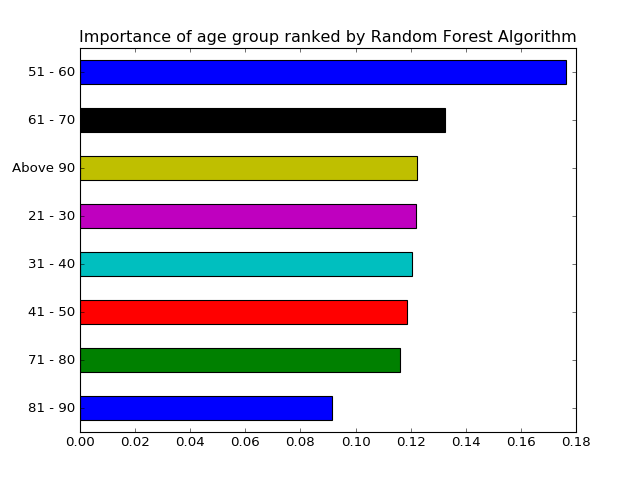

In [226]:
importance.plot(kind='barh', title = "Importance of age group ranked by Random Forest Algorithm")

According to the algorithm, the most important age group in deciding Y2018 election results is the AGE group 51-60, with the largest importance weight across all age groups (17% weightage) 

### Caveats/Disclaimers on this results

Please note this is a modelled output. 

One notable weakness of this result is the age data itself: while I have no reason to doubt the data is reliable - the fact of the matter is we are unable to validate each voter's age (voters that actually showed up and voted). This is because voting is an anonyamous behavior, there are no demographic data points attached to each vote.

Instead, this is an analysis based on REGISTERED voters. It is entirely possible for one to be registered, but did not show up to vote on polling day.